In [3]:
import pandas as pd
import os
import time
from transformers import pipeline
import re
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import nltk 
from nltk.corpus import stopwords
import emoji
import numpy as np
from tqdm import tqdm
import seaborn as sns
import dataframe_image as dfi
import warnings

In [6]:
pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 200
warnings.filterwarnings('ignore')

In [8]:
PATH_CONSOLIDADO = '../data_consolidated/'
files = sorted(os.listdir(PATH_CONSOLIDADO))
files

['dataTW_GP__(@JaimeChincha.csv',
 'dataTW_GP__(RMP.csv',
 'dataTW_GP__@AlejandroCavero.csv',
 'dataTW_GP__@Alm_Montoya.csv',
 'dataTW_GP__@HectorValer_PER.csv',
 'dataTW_GP__@JaimeChincha.csv',
 'dataTW_GP__@LadyCamones.csv',
 'dataTW_GP__@PedroCastilloTe.csv',
 'dataTW_GP__@SilvaVJ_.csv',
 'dataTW_GP__@anibaltorresv.csv',
 'dataTW_GP__@interbank.csv',
 'dataTW_GP__Alfonso.csv',
 'dataTW_GP__Ángel.csv',
 'dataTW_GP__Hernan.csv',
 'dataTW_GP__Hernán.csv',
 'dataTW_GP__Malcricarmen.csv',
 'dataTW_GP__Vacancia.csv',
 'dataTW_GP__hildebrant.csv',
 'dataTW_GP__pbodigital.csv',
 'dataTW_GP__repsol.csv',
 'dataTW_GP__willax.csv',
 'usersTW_GP__(@JaimeChincha.csv',
 'usersTW_GP__(RMP.csv',
 'usersTW_GP__@HectorValer_PER.csv',
 'usersTW_GP__@JaimeChincha.csv',
 'usersTW_GP__@LadyCamones.csv',
 'usersTW_GP__@PedroCastilloTe.csv',
 'usersTW_GP__@SilvaVJ_.csv',
 'usersTW_GP__@interbank.csv',
 'usersTW_GP__Alfonso.csv',
 'usersTW_GP__Ángel.csv',
 'usersTW_GP__Hernan.csv',
 'usersTW_GP__Hernán.

In [9]:
data = {}
for file in files:
    data[file] = pd.read_csv(os.path.join(PATH_CONSOLIDADO, file))

In [14]:
def get_public_metrics(dataset:pd.DataFrame)->pd.DataFrame:
    '''Extrae la columna "public_metrics" que se encuentra en el dataset'''
    df_public = pd.DataFrame()
    for i, row in dataset.iterrows():
        public_metrics = eval(row['public_metrics'])
        public_metrics['id'] = row['id']
        df_i = pd.DataFrame([public_metrics])
        df_public = df_public.append(df_i).reset_index(drop=True)        
    return df_public

def get_referenced_tweets(dataset:pd.DataFrame)->pd.DataFrame:
    '''Extrae la columna "referenced_tweets" que se encuentra en el dataset'''
    df_referenced = pd.DataFrame()
    for i, row in dataset.iterrows():
        try:
            referenced_tweets = eval(row['referenced_tweets'])[0]
            referenced_tweets['id_ref'] = referenced_tweets['id']
        except:
            referenced_tweets = {}
        referenced_tweets['id'] = row['id']

        df_i = pd.DataFrame([referenced_tweets])
        df_referenced = df_referenced.append(df_i)
    return df_referenced

def get_words_by_key(text:str, key:str)->list:
    '''Obtiene el listado de palabras que empiezan por un key. Útil para colectar links, menciones y hashtags'''
    indexes = [i for i in range(len(text)) if text.startswith(key, i)]
    words = [text[x:].split(' ')[0] for x in indexes]
    return words

def get_clean_text(text:str)->str:
    '''Limpia el texto eliminando las menciones'''
#    hashtags = get_words_by_key(text, '#')
    mentions = get_words_by_key(text, '@')
    links = get_words_by_key(text, 'http')
    emojis = get_emojis(text)
    
    for word in mentions+links+emojis: # No se borrarán hashtags
        text = text.replace(word, '')
    text = clean_vowels(text)
    text = clean_punctuation(text)    
    text = text.replace('  ', ' ').replace('  ', ' ').replace('  ', ' ')
    text = text.replace(' ,', '')
    text = text.replace('\n', '').strip()
    return text


def get_sentiment_and_prob(text:str, sentiment:pipeline)->float:
    '''Evaluates and predicts the sentiment based on a text'''
    pred = sentiment(text)[0]
    preds = int(pred['label'][0]) + pred['score']
    return preds



def clean_vowels(text:str)->str:
    text = text.lower()
    vowels_l1 = {
        'a':['ä','â','á','à'],
        'e':['ë','ê','é','è'],
        'i':['ï','î','í','ì'],
        'o':['ö','ô','ó','ò'],
        'u':['ü','û','ú','ù']
    }

    vowels_l2 = {}
    for key in vowels_l1:
        for value in vowels_l1[key]:
            vowels_l2[value] = key
    
    for key in vowels_l2:
        text = text.replace(key, vowels_l2[key])
    return text

def clean_punctuation(text:str)->str:
    punctuation = '!"#$%&\()*…+,-./:;<=>?@^_`{|}~¿`~«¨'
    text = re.sub(f'[{punctuation}]', ' ', text)
    return text

def get_emojis(text:str)->list:
    emojis = [x for x in text if x in emoji.UNICODE_EMOJI['en']]
    return emojis

def get_upper_words(text:str)->list:
    emojis = [x for x in text if x in emoji.UNICODE_EMOJI['en']]
    for emj in emojis:
        text = text.replace(emj, '')
    upper_words = [x.replace(',','') for x in text.split() if (len(x)>2) and (x==x.upper())]
    return upper_words

def get_stop_words(text_serie:pd.Series, top_n:int=50, n_len:int=3)->list:
    '''Obtains stopwords from text as the most frequent short words and nltk stopwords'''
    # Detect Stopwords
    full_text = ' '.join(text_serie.to_list())
    full_text = full_text.lower()
    words = pd.Series(full_text.split()).value_counts().head(top_n)
    detected_stop_words = [w for w in words.index if len(w) <= n_len]
    
    # Nltk Stopwords
    stop_words = detected_stop_words + stopwords.words('spanish')
    stop_words = sorted(list(set(stop_words)))
    return stop_words

def get_normalized_text(text:str, stop_words:list=None)->str:
    text = text.lower()
    if stop_words:
        text = ' '.join([x for x in text.split() if x not in stop_words])
    text = text.replace('  ',' ').replace('  ',' ').replace('  ',' ')
    text = text.replace('  ',' ').replace('  ',' ').replace('  ',' ')
    return text


def process_dataset(dataset:pd.DataFrame, print_progress:bool=False) -> pd.DataFrame:
    '''Realiza todo el procesamiento de limpieza con las funciones antes definidas'''
    start_time = time.time()
    dataset_1 = dataset.copy()
    
    # Obtaining Json Data
    public_metrics = get_public_metrics(dataset)
    referenced_tweets = get_referenced_tweets(dataset)
    
    # Merging Json Data
    dataset_1 = dataset_1.merge(public_metrics, on='id', how='left')
    dataset_1 = dataset_1.merge(referenced_tweets, on='id', how='left')
    dataset_1 = dataset_1.drop(['public_metrics', 'geo', 'referenced_tweets'], axis=1)
    if print_progress:
        print('INFO: Jsons procesed and merged')
    
    # Cleaning Data Elements
    dataset_1['mentions'] = dataset_1['text'].apply(get_words_by_key, args=['@'])
    dataset_1['hashtags'] = dataset_1['text'].apply(get_words_by_key, args=['#'])
    dataset_1['links'] = dataset_1['text'].apply(get_words_by_key, args=['http'])
    dataset_1['emojis'] = dataset_1['text'].apply(get_emojis)
    dataset_1['upper_words'] = dataset_1['text'].apply(get_upper_words)
    
    dataset_1['num_mentions'] = dataset_1['mentions'].str.len()
    dataset_1['num_hashtags'] = dataset_1['hashtags'].str.len()
    dataset_1['num_links'] = dataset_1['links'].str.len()
    dataset_1['num_emojis'] = dataset_1['emojis'].str.len()
    dataset_1['num_upper_words'] = dataset_1['upper_words'].str.len()
    
    dataset_1['date'] = pd.to_datetime(dataset_1['created_at'].str[:10])
    
    if print_progress:
        print('INFO: List of elements processed')
    
    dataset_1['clean_text'] = dataset_1['text'].apply(get_clean_text)
    stop_words = get_stop_words(dataset_1['clean_text'])
    dataset_1['norm_text'] = dataset_1['clean_text'].apply(get_normalized_text, args=[stop_words])
    if print_progress:
        print('INFO: Text cleaned')
    
    # Process Sentiment Data
    if print_progress:
        print('INFO: Processing Sentiment')
    tqdm.pandas()
    dataset_1['sentiment_output'] = dataset_1['clean_text'].progress_apply(get_sentiment_and_prob, args=[sentiment])
    dataset_1['sentiment_pred'] = (dataset_1['sentiment_output']//1).astype(int)
    dataset_1['sentiment_conf'] = dataset_1['sentiment_output']%1
    dataset_1['sentiment_pred_conf45'] = np.nan
    dataset_1.loc[dataset_1['sentiment_conf']>0.45, 'sentiment_pred_conf45']=dataset_1['sentiment_pred']
    if print_progress:
        print('INFO: Sentiment Obtained')
    
    processing_time = (time.time() - start_time)
    
    if print_progress:
        print(f'INFO: Processing Time:\t{processing_time:.2f} seconds')

    return dataset_1

In [15]:
def get_emoji_table(emoji_serie:pd.Series, top_n:int=10):
    emoji_serie_joined = emoji_serie.apply(lambda x: ' '.join(x))
    emoji_list = ' '.join(emoji_serie_joined.to_list())
    emoji_counter = pd.Series(emoji_list.split()).value_counts().head(top_n)
    emoji_counter = emoji_counter.to_frame('ocurrencias').T
    return emoji_counter

def generate_wordcloud(text_serie:pd.Series,
                       extra_title:str='', 
                       figsize:tuple=(15,6),
                       fontsize:int=26,
                       color='#347FC4',
                       fontname='Helvetica'
                      ):
    '''Plots a WordCloud based on a pd serie of Texts.
    The text should preferably be cleaned and normalized.'''
    
    full_text = ' '.join(text_serie.to_list())

    wordcloud = WordCloud(background_color="white", max_font_size=50, max_words=50)
    wordcloud = wordcloud.generate(full_text)

#    plt.figure(figsize=figsize)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    title = f'WordCloud {extra_title}'
    plt.title(title, fontsize=fontsize, color=color, fontname=fontname)
#    plt.show()

def plot_from_list_serie(list_serie:pd.Series, 
                         n:int=10, 
                         figsize:tuple=(8,3),
                         color:str='orange',
                         fontname:str='helvetica',
                         fontsize:int=16
                        ):
    serie = list_serie.apply(lambda x: ' '.join(x))
    list_from_serie = ' '.join(serie.to_list())
    serie_counted = pd.Series(list_from_serie.split()).value_counts()
#    fig = plt.figure()
    serie_counted = serie_counted.head(n).sort_values()
    plt.barh(y=serie_counted.index, width=serie_counted.values, color=color)
    plt.title(f'Top {n} {serie.name}', color=color, fontname=fontname, fontsize=fontsize)
    plt.axvline(0)
    sns.despine()
#    plt.axis('x')

def plot_barchart(serie, 
                  title = 'Cantidad de Tweets', 
                  fontsize=26,
                  fontname='Helvetica',
                  color='Orange',
                  rotation=90
                 ):
    plt.bar(x=serie.index, height=serie.values)
    plt.title(title, fontsize=fontsize, fontname=fontname, color=color)
    sns.despine()
    plt.xticks(rotation=90);

In [11]:
# Initialize Sentiment Model
model_multilingual_path = 'nlptown/bert-base-multilingual-uncased-sentiment'
sentiment = pipeline(task = 'sentiment-analysis',
                     model = model_multilingual_path,
                     tokenizer = model_multilingual_path)

In [8]:
## Too heavy 1 Gb - Try later
#model_twitter_path = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
#sentiment_twitter = pipeline(task = 'sentiment-analysis', 
#                             model=model_twitter_path, 
#                             tokenizer=model_twitter_path)

In [12]:
dataset = data['dataTW_GP__hildebrant.csv']#.head(100)

In [16]:
dataset = process_dataset(dataset, print_progress=True)

INFO: Jsons procesed and merged
INFO: List of elements processed
INFO: Text cleaned
INFO: Processing Sentiment


100%|██████████████████████████████████████████████████████| 1250/1250 [02:25<00:00,  8.60it/s]

INFO: Sentiment Obtained
INFO: Processing Time:	147.81 seconds


In [17]:
keyword = dataset['keyword'].values[0].split('-')[0].strip()

In [18]:
# Export de Emojis
report = get_emoji_table(dataset['emojis'])
dfi.export(report, f'{keyword}_emojis.png')
img = plt.imread(f'{keyword}_emojis.png')

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[0221/224511.273212:ERROR:xattr.cc(63)] setxattr org.chromium.crashpad.database.initialized on file /var/folders/3m/rffll2kn2t59dds4qx69f7ww0000gp/T/: Operation not permitted (1)
[0221/224511.275466:ERROR:file_io.cc(94)] ReadExactly: expected 8, observed 0
[0221/224511.276559:ERROR:xattr.cc(63)] setxattr org.chromium.crashpad.database.initialized on file /var/folders/3m/rffll2kn2t59dds4qx69f7ww0000gp/T/: Operation not permitted (1)
[0221/224512.153732:INFO:headless_shell.cc(659)] Written to file /var/folders/3m/rffll2kn2t59dds4qx69f7ww0000gp/T/tmpru37ip6z/temp.png.
[0221/224512.155911:ERROR:node_controller.cc(585)] Trying to re-add dropped peer 16998B4C5EA44045.AAD3279447BE81D9


In [118]:
def plot_report(
    # PLOT FINAL
    dataset,
    figsize=(16,30), 
    fontsize=26,
    color='#347FC4',
    fontname='Helvetica',
    nrows=7,
    ncols=2,
    i=1
):
    keyword = dataset['keyword'].values[0].split('-')[0].strip()
    
    # Export de Emojis
    report = get_emoji_table(dataset['emojis'])
    dfi.export(report, f'{keyword}_emojis.png')
    img = plt.imread(f'{keyword}_emojis.png')

    
    fig = plt.figure(figsize=figsize)
    
    fig.add_subplot(nrows,ncols,i)
    first_title = f'Reporte de Data extraída\nde Twitter\n\nKeyword - {keyword}'
    plt.text(x=0.5, y=0.5, s=first_title, 
             fontdict={'fontsize':'40',
                       'fontweight':'bold',
                       'ha':'center',
                       'va':'center',
                       'color':color,
                       'fontname':fontname})

    plt.axis('off')


    i+=1
    fig.add_subplot(nrows,ncols,i)
    # Conteo de Sentimiento
    serie = dataset['sentiment_pred'].value_counts().sort_index()
    colors = ['#7bdff2', '#b2f7ef', '#eff7f6', '#f7d6e0', '#f2b5d4']
    plt.pie(serie, labels=serie.index, 
            autopct='%.1f%%', 
            pctdistance=0.75,
            colors=colors,
            labeldistance=1.03,
            startangle=90,
            textprops={'size': 'large'},
            wedgeprops={'linewidth': 1.0, 'edgecolor': 'white'}
            )
    plt.text(1,0.8,'Multilingual Sent\n1: Bad\n5: Good')
    plt.title('Distribución de Sentimiento', fontname=fontname, fontsize=fontsize, color=color)



    i+=1
    fig.add_subplot(nrows,ncols,i)
    # Conteo de Tweets
    serie = dataset.groupby('date').agg({'text':'count'})['text']
    title = 'Cantidad de Tweets'
    plot_barchart(serie, title='Cantidad de Tweets', 
                  fontsize=fontsize, fontname=fontname, color=color)


    i+=1
    fig.add_subplot(nrows,ncols,i)
    # WordCloud Total Texto Limpio y Normalizado
    generate_wordcloud(dataset['norm_text'], extra_title='Tweets', fontsize=fontsize, color=color, fontname=fontname)


    i+=1
    fig.add_subplot(nrows,ncols,i)
    # Sentiment Promedio en el tiempo
    serie = dataset.groupby('date').agg({'sentiment_pred_conf45':'mean'})['sentiment_pred_conf45']
    title = 'Sentiment Promedio'
    plt.plot(serie, marker='o', linestyle='-.', linewidth=0.5, color=color, mec='r', mfc='r')
    plt.title(title, fontname=fontname, fontsize=fontsize, color=color)
    sns.despine()
    plt.xticks(rotation=90);


    i+=1
    fig.add_subplot(nrows,ncols,i)
    # Top Emojis
    plt.imshow(img)
    plt.title('Top Emojis en Tweets', fontsize=fontsize, color=color, fontname=fontname)
    plt.axis('off')


    i+=1
    fig.add_subplot(nrows,ncols,i)
    # Top Mentions
    plot_from_list_serie(dataset['mentions'], fontsize=fontsize, color=color, fontname=fontname)


    i+=1
    fig.add_subplot(nrows,ncols,i)
    # WordCloud Mentions
    generate_wordcloud(dataset['mentions'].apply(lambda x: ' '.join(x)), 
                       extra_title='Mentions', fontsize=fontsize, color=color, fontname=fontname)


    i+=1
    fig.add_subplot(nrows,ncols,i)
    # Top Hashtags
    plot_from_list_serie(dataset['hashtags'], fontsize=fontsize, color=color, fontname=fontname)


    i+=1
    fig.add_subplot(nrows,ncols,i)
    # WordCloud Hashtags
    generate_wordcloud(dataset['hashtags'].apply(lambda x: ' '.join(x)), 
                       extra_title='Hashtags', fontsize=fontsize, color=color, fontname=fontname)


    i+=1
    fig.add_subplot(nrows,ncols,i)
    # Top Mayusculos
    plot_from_list_serie(dataset['upper_words'], fontsize=fontsize, color=color, fontname=fontname)


    i+=1
    fig.add_subplot(nrows,ncols,i)
    # WordCloud Mayusculos
    generate_wordcloud(dataset['upper_words'].apply(lambda x: ' '.join(x)), 
                       extra_title='Mayusculas', fontsize=fontsize, color=color, fontname=fontname)


    plt.tight_layout();
    fig.savefig(f'Reporte_{keyword}.pdf');

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[0222/003524.858058:ERROR:xattr.cc(63)] setxattr org.chromium.crashpad.database.initialized on file /var/folders/3m/rffll2kn2t59dds4qx69f7ww0000gp/T/: Operation not permitted (1)
[0222/003524.859307:ERROR:file_io.cc(94)] ReadExactly: expected 8, observed 0
[0222/003524.861881:ERROR:xattr.cc(63)] setxattr org.chromium.crashpad.database.initialized on file /var/folders/3m/rffll2kn2t59dds4qx69f7ww0000gp/T/: Operation not permitted (1)
[0222/003525.709574:INFO:headless_shell.cc(659)] Written to file /var/folders/3m/rffll2kn2t59dds4qx69f7ww0000gp/T/tmpsv0p6rup/temp.png.


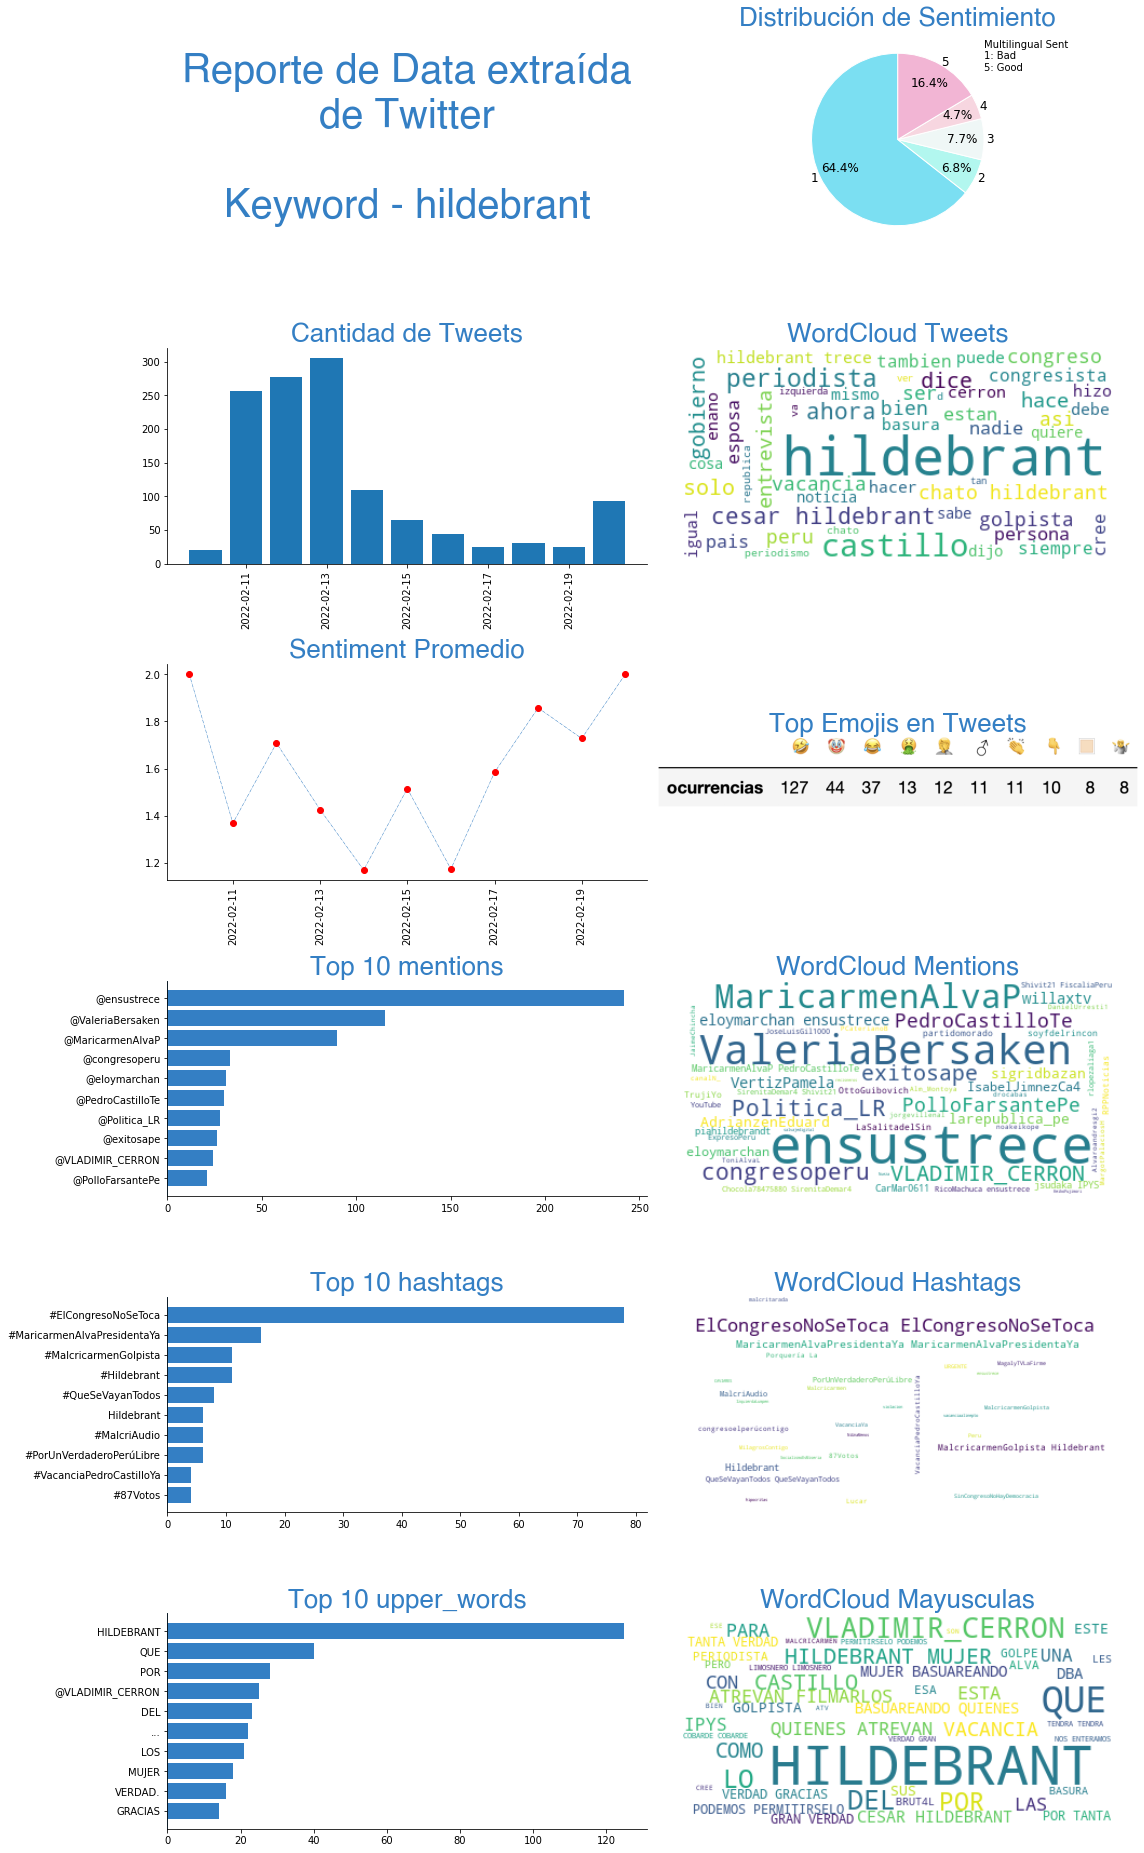

In [119]:
plot_report(dataset)

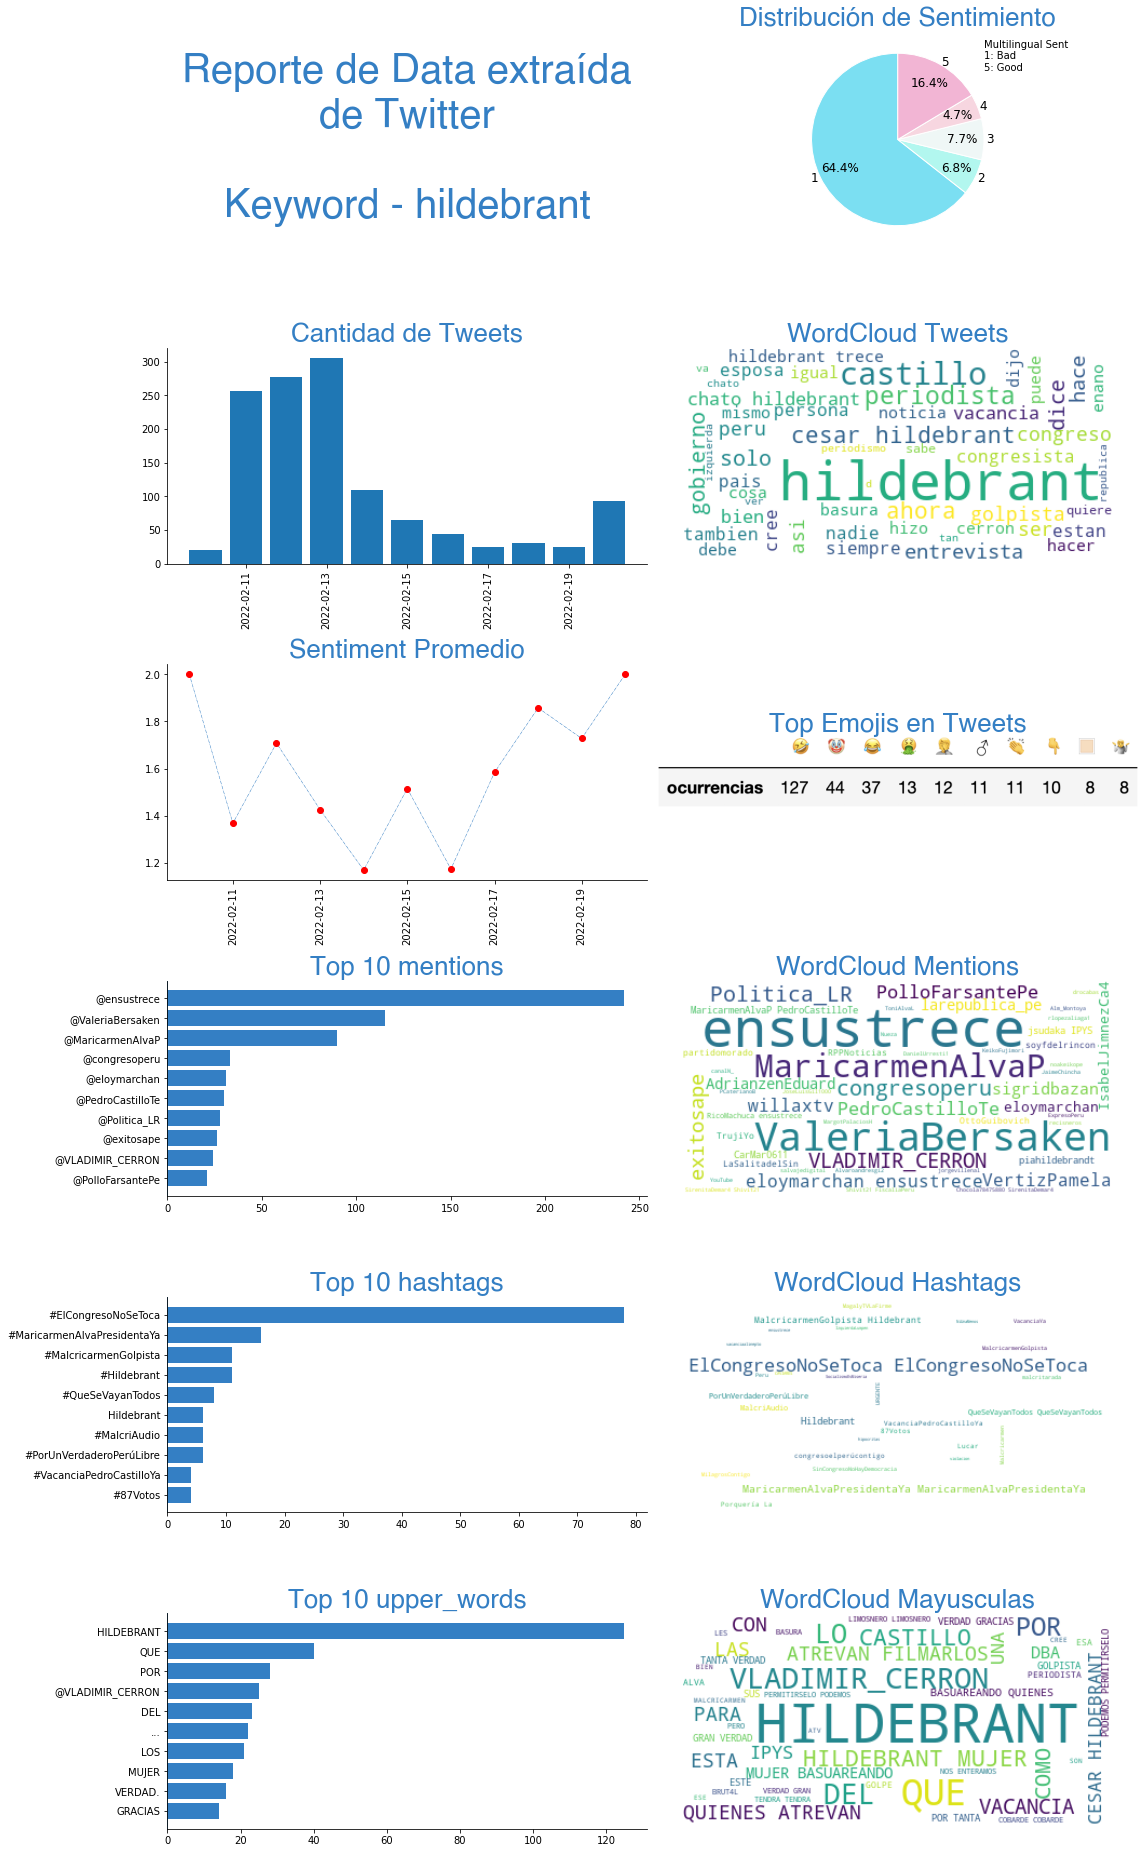

In [105]:
# PLOT FINAL
fig = plt.figure(figsize=(16,30))
fontsize=26
color='#347FC4'
fontname='Helvetica'
nrows=7
ncols=2
i=1


fig.add_subplot(nrows,ncols,i)
first_title = f'Reporte de Data extraída\nde Twitter\n\nKeyword - {keyword}'
plt.text(x=0.5, y=0.5, s=first_title, 
         fontdict={'fontsize':'40',
                   'fontweight':'bold',
                   'ha':'center',
                   'va':'center',
                   'color':color,
                   'fontname':fontname})

plt.axis('off')


i+=1
fig.add_subplot(nrows,ncols,i)
# Conteo de Sentimiento
serie = dataset['sentiment_pred'].value_counts().sort_index()
colors = ['#7bdff2', '#b2f7ef', '#eff7f6', '#f7d6e0', '#f2b5d4']
plt.pie(serie, labels=serie.index, 
        autopct='%.1f%%', 
        pctdistance=0.75,
        colors=colors,
        labeldistance=1.03,
        startangle=90,
        textprops={'size': 'large'},
        wedgeprops={'linewidth': 1.0, 'edgecolor': 'white'}
        )
plt.text(1,0.8,'Multilingual Sent\n1: Bad\n5: Good')
plt.title('Distribución de Sentimiento', fontname=fontname, fontsize=fontsize, color=color)



i+=1
fig.add_subplot(nrows,ncols,i)
# Conteo de Tweets
serie = dataset.groupby('date').agg({'text':'count'})['text']
title = 'Cantidad de Tweets'
plot_barchart(serie, title='Cantidad de Tweets', 
              fontsize=fontsize, fontname=fontname, color=color)


i+=1
fig.add_subplot(nrows,ncols,i)
# WordCloud Total Texto Limpio y Normalizado
generate_wordcloud(dataset['norm_text'], extra_title='Tweets', fontsize=fontsize, color=color, fontname=fontname)


i+=1
fig.add_subplot(nrows,ncols,i)
# Sentiment Promedio en el tiempo
serie = dataset.groupby('date').agg({'sentiment_pred_conf45':'mean'})['sentiment_pred_conf45']
title = 'Sentiment Promedio'
plt.plot(serie, marker='o', linestyle='-.', linewidth=0.5, color=color, mec='r', mfc='r')
plt.title(title, fontname=fontname, fontsize=fontsize, color=color)
sns.despine()
plt.xticks(rotation=90);


i+=1
fig.add_subplot(nrows,ncols,i)
# Top Emojis
plt.imshow(img)
plt.title('Top Emojis en Tweets', fontsize=fontsize, color=color, fontname=fontname)
plt.axis('off')


i+=1
fig.add_subplot(nrows,ncols,i)
# Top Mentions
plot_from_list_serie(dataset['mentions'], fontsize=fontsize, color=color, fontname=fontname)


i+=1
fig.add_subplot(nrows,ncols,i)
# WordCloud Mentions
generate_wordcloud(dataset['mentions'].apply(lambda x: ' '.join(x)), 
                   extra_title='Mentions', fontsize=fontsize, color=color, fontname=fontname)


i+=1
fig.add_subplot(nrows,ncols,i)
# Top Hashtags
plot_from_list_serie(dataset['hashtags'], fontsize=fontsize, color=color, fontname=fontname)


i+=1
fig.add_subplot(nrows,ncols,i)
# WordCloud Hashtags
generate_wordcloud(dataset['hashtags'].apply(lambda x: ' '.join(x)), 
                   extra_title='Hashtags', fontsize=fontsize, color=color, fontname=fontname)


i+=1
fig.add_subplot(nrows,ncols,i)
# Top Mayusculos
plot_from_list_serie(dataset['upper_words'], fontsize=fontsize, color=color, fontname=fontname)


i+=1
fig.add_subplot(nrows,ncols,i)
# WordCloud Mayusculos
generate_wordcloud(dataset['upper_words'].apply(lambda x: ' '.join(x)), 
                   extra_title='Mayusculas', fontsize=fontsize, color=color, fontname=fontname)


plt.tight_layout();
fig.savefig(f'Reporte_{keyword}.pdf')

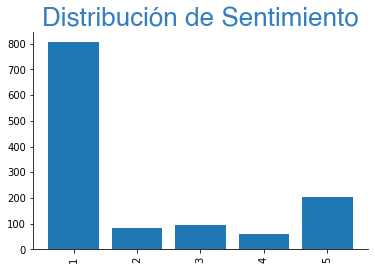

In [22]:
serie = dataset['sentiment_pred'].value_counts().sort_index()
plt.bar(serie.index, serie.values)
plt.title('Distribución de Sentimiento', fontname=fontname, fontsize=fontsize, color=color)
sns.despine()
plt.xticks(rotation=90);

In [477]:
dataset.to_csv('dataset_procesado.csv', index=False)

# Pruebas Sin Éxito

## Name Entity Recognition

In [ ]:
## TODO : Name Entity Recognition + WordCloud

In [494]:
import spacy
from spacy import displacy
from collections import Counter

In [493]:
!python -m spacy download es_core_news_md

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
     |████████████████████████████████| 43.4 MB 467 kB/s            
You should consider upgrading via the '/Users/gabpila/Documents/CodingPersonal/twitter-extractor/venv/bin/python -m pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_md')


In [495]:
import es_core_news_md
nlp = es_core_news_md.load()

In [509]:
full_text = ' '.join(dataset['norm_text'].to_list())
document = nlp(full_text)

In [510]:
full_text

'jajaja lucar hildebrant jajaj bien payaso canal n tambien ta comprado zurdos enano hildebrant cree colon quiere descubrir sabe hace tiempo igual nadie compra pasquin gracias hildebrant 13 conocemos verdad cosas medios seguiriamos viviendo mentiras anteriores gobiernos bueno reunan vaciar castillo hildebrant creo hora retires pienso periodismo peru pienso guaripoleras mermelada mediatraining lucar hildebrant lagarto enano comunista doble cara cesar hildebrant mujer pituca discriminadora chato hildebrant sabe puede inventa cuento zopencos tontos utiles d siempre congresistas deben denunciar difamacion calumnia mono metralleta denuncia tambien chato hildebrant pedir reparacion civil muerto hambre escuchar hildebrant entrar baño publico usado 40 000 borrachos diarrea verdad golpista aca cesar hildebrant deleznable armo tremenda novela difamadora hacia congreso hombre deberia preso x calumniador maldito congresoelperucontigo vacanciapedrocastilloya periodismo existe peru quiza hildebrant s

In [511]:
for named_entity in document.ents:
    print(named_entity, named_entity.label_)

jajaja lucar hildebrant jajaj PER
hildebrant PER
hildebrant PER
hildebrant mujer pituca discriminadora chato hildebrant PER
tambien chato hildebrant MISC
hildebrant PER
aca cesar hildebrant PER
preso x calumniador maldito congresoelperucontigo vacanciapedrocastilloya MISC
hildebrant PER
keiko PER
hildebrant PER
hildebrant PER
hildebrant PER
hildebrant PER
hildebrant PER
hildebrant PER
hildebrant PER
hildebrant PER
friedrich naumann traves PER
margot PER
hildebrant PER
hildebrant PER
hildebrant PER
hildebrant magaly PER
ocupate ampay PER
hildebrant PER
hildebrant PER
pasquin hildebrant PER
ud hildebrant mermelero PER
fujimori PER
hildebrant PER
hildebrant PER
hildebrant PER
hildebrant PER
hildebrant PER
hildebrant PER
hildebrant PER
hildebrant PER
hildebrant PER
lucar hildebrant PER
hildebrant PER
señor hildebrant PER
hildebrant PER
castillo churchill PER
hildebrant PER
hildebrant PER
hildebrant PER
hildebrant PER
señor hildebrant PER
hildebrant yap terronica hildebrant PER
hildebrant P

## Topic Modelling

In [12]:
# TOP 2 VEC Modelling

In [28]:
from top2vec import Top2Vec

In [38]:
docs = dataset['norm_text'].values
docs_ids = dataset['id'].values

In [30]:
topic_model = Top2Vec(documents=docs,
                      embedding_model='universal-sentence-encoder-multilingual',
                      document_ids=docs_ids)

2022-02-20 17:00:29,084 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
/Users/gabpila/Documents/CodingPersonal/twitter-extractor/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
2022-02-20 17:00:30,575 - top2vec - INFO - Downloading universal-sentence-encoder-multilingual model
INFO:top2vec:Downloading universal-sentence-encoder-multilingual model
2022-02-20 17:00:34,059 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2022-02-20 17:00:59,394 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2022-02-20 17:01:46,437 - top2vec - INFO - Finding dense areas of documents

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

2022-02-20 17:01:49,028 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics


In [39]:
topic_model.get_num_topics()

178

In [40]:
topic_words, word_scores, topic_nums = topic_model.get_topics()

In [41]:
topic_sizes, _ = topic_model.get_topic_sizes()
topic_sizes

array([1532, 1201,  974,  908,  878,  731,  644,  636,  585,  571,  537,
        526,  503,  499,  487,  462,  388,  376,  368,  365,  325,  321,
        317,  309,  299,  281,  278,  268,  266,  258,  255,  232,  230,
        219,  215,  205,  203,  201,  201,  199,  194,  186,  182,  170,
        160,  157,  151,  148,  145,  145,  139,  138,  137,  134,  133,
        132,  127,  123,  123,  121,  117,  115,  113,  109,  102,   98,
         96,   96,   95,   95,   93,   92,   91,   91,   91,   89,   88,
         87,   87,   85,   85,   83,   80,   77,   77,   76,   75,   74,
         72,   72,   70,   70,   69,   69,   66,   66,   66,   65,   65,
         64,   63,   63,   62,   62,   62,   60,   60,   60,   60,   59,
         58,   58,   58,   53,   53,   53,   52,   51,   51,   50,   49,
         49,   49,   49,   49,   48,   46,   46,   45,   45,   45,   44,
         43,   43,   43,   43,   42,   42,   41,   41,   40,   39,   38,
         38,   38,   37,   36,   36,   35,   34,   

In [42]:
topic_words, word_scores, topic_nums = topic_model.get_topics()

In [43]:
topic_words

array([['vacancia', 'vacanciaya', 'vacadores', ..., 'ociosas', 'ir',
        'semana'],
       ['congreso', 'congresal', 'congresista', ..., 'dictador',
        'constituyente', 'votos'],
       ['peruanos', 'peruano', 'peruana', ..., 'irse', 'referendum',
        'incompetentes'],
       ...,
       ['keiko', 'comunista', 'comunistas', ..., 'delincuencia', 'dia',
        'vacancia'],
       ['indignidad', 'indignacion', 'patriotas', ..., 'gobernar',
        'terrorista', 'corruptos'],
       ['miraflores', 'miraflorino', 'hotel', ..., 'renuncia', 'espero',
        'oportunidad']], dtype='<U15')